# Day32 (2025-08-05)
- 결정트리, XGBoost 모델 제작 및 실습

In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1500 # 샘플 수

# 기본 인구 통계
성별 = np.random.choice(['남', '여'], n)
나이 = np.random.normal(loc=45, scale=12, size=n).astype(int)
나이 = np.clip(나이, 20, 80)

# 라이프스타일
수면시간 = np.round(np.random.normal(loc=6.5, scale=1.5, size=n), 1)
운동빈도 = np.random.choice(['주1회 이하', '주2~3회', '주4회 이상'], n, p=[0.4, 0.4, 0.2])
흡연여부 = np.random.choice(['비흡연', '과거흡연', '현재흡연'], n, p=[0.5, 0.2, 0.3])
음주빈도 = np.random.choice(['거의안함', '주1회', '주2회 이상'], n, p=[0.3, 0.4, 0.3])

# 건강 수치
BMI = np.round(np.random.normal(loc=24, scale=4, size=n), 1)
수축기혈압 = np.round(np.random.normal(loc=125, scale=15, size=n), 1)
공복혈당 = np.round(np.random.normal(loc=95, scale=20, size=n), 1)
콜레스테롤 = np.round(np.random.normal(loc=200, scale=30, size=n), 1)

# 질병위험 생성 (가짜 알고리즘)
risk_score = (
    (BMI > 27).astype(int) +
    (수축기혈압 > 135).astype(int) +
    (공복혈당 > 110).astype(int) +
    (콜레스테롤 > 240).astype(int) +
    (흡연여부 == '현재흡연').astype(int) +
    (운동빈도 == '주1회 이하').astype(int)
)

질병위험 = (risk_score >= 3).astype(int)

# 데이터프레임 구성
df = pd.DataFrame({
    '성별': 성별,
    '나이': 나이,
    '수면시간': 수면시간,
    '운동빈도': 운동빈도,
    '흡연여부': 흡연여부,
    '음주빈도': 음주빈도,
    'BMI': BMI,
    '수축기혈압': 수축기혈압,
    '공복혈당': 공복혈당,
    '콜레스테롤': 콜레스테롤,
    '질병위험': 질병위험
})

df.head()

,성별,나이,수면시간,운동빈도,흡연여부,음주빈도,BMI,수축기혈압,공복혈당,콜레스테롤,질병위험
0,남,27,6.3,주1회 이하,현재흡연,거의안함,28.2,124.8,89.4,189.0,1
1,여,58,5.8,주1회 이하,비흡연,주1회,22.3,110.3,97.5,200.9,0
2,남,49,6.5,주2~3회,과거흡연,주2회 이상,31.0,102.5,103.9,189.5,0
3,남,40,7.4,주2~3회,비흡연,주2회 이상,22.5,135.9,103.7,227.1,0
4,남,52,4.3,주2~3회,현재흡연,주2회 이상,20.6,135.4,79.9,206.5,0


## 1. 데이터 전처리

### 성별

In [3]:
df['성별코드']=df['성별'].map({'남' : 0, '여' : 1})
df['성별코드'].value_counts()

성별코드
0    753
1    747
Name: count, dtype: int64

### 운동빈도, 흡연여부, 음주빈도

In [ ]:
df=pd.get_dummies(df, columns=['운동빈도', '흡연여부', '음주빈도'], drop_first=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   성별           1500 non-null   object 
 1   나이           1500 non-null   int64  
 2   수면시간         1500 non-null   float64
 3   BMI          1500 non-null   float64
 4   수축기혈압        1500 non-null   float64
 5   공복혈당         1500 non-null   float64
 6   콜레스테롤        1500 non-null   float64
 7   질병위험         1500 non-null   int64  
 8   성별코드         1500 non-null   int64  
 9   운동빈도_주2~3회   1500 non-null   bool   
 10  운동빈도_주4회 이상  1500 non-null   bool   
 11  흡연여부_비흡연     1500 non-null   bool   
 12  흡연여부_현재흡연    1500 non-null   bool   
 13  음주빈도_주1회     1500 non-null   bool   
 14  음주빈도_주2회 이상  1500 non-null   bool   
dtypes: bool(6), float64(5), int64(3), object(1)
memory usage: 114.4+ KB


## 2. 모델 제작

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

X=df.drop(columns=['질병위험', '성별'], axis=1)
y=df['질병위험']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### 성능 평가 함수 제작

In [8]:
matplotlib.rc('font', family='Malgun Gothic')
def evaluate_model(mod, model, thr=0.5):
    y_proba=model.predict_proba(X_test)[:,1]
    y_pred=(y_proba >= thr).astype(int)

    print('confusion matrix : \n', confusion_matrix(y_test, y_pred))
    print('정밀도 :', precision_score(y_test, y_pred))
    print('재현율 :', recall_score(y_test, y_pred))
    print('f1 score :', f1_score(y_test, y_pred))
    print('AUC :', roc_auc_score(y_test, y_proba))

    fpr, tpr, thresholds=roc_curve(y_test, y_proba)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'{model}(AUC = {roc_auc_score(y_test, y_proba)})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(f'{mod} ROC Curve')
    plt.legend
    plt.grid()

    plt.subplot(1,2,2)
    precisions, recalls, threshold=precision_recall_curve(y_test, y_proba)
    plt.plot(threshold, precisions[:-1], 'b--', label='정밀도')
    plt.plot(threshold, recalls[:-1], 'g-', label='재현율')
    plt.xlabel('Threshold')
    plt.ylabel('score')
    plt.title(f'{mod} 정밀도 vs 재현율 트레이드오프')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### 모델 제작

**1. 결정트리**

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth =5, random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**2. XGBoost**

In [10]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encodeer = False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

c:\Users\kgh44\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encodeer" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### 성능평가

confusion matrix : 
 [[249   5]
 [ 11  35]]
정밀도 : 0.875
재현율 : 0.7608695652173914
f1 score : 0.813953488372093
AUC : 0.9703012666894898


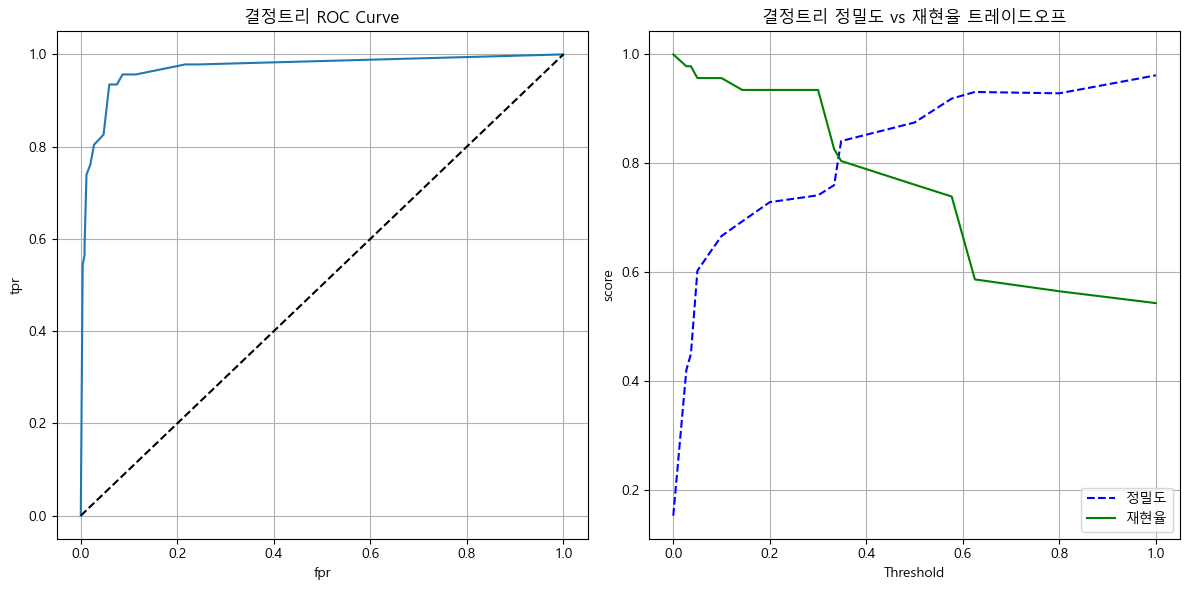

confusion matrix : 
 [[254   0]
 [  4  42]]
정밀도 : 1.0
재현율 : 0.9130434782608695
f1 score : 0.9545454545454546
AUC : 0.9994008901061281


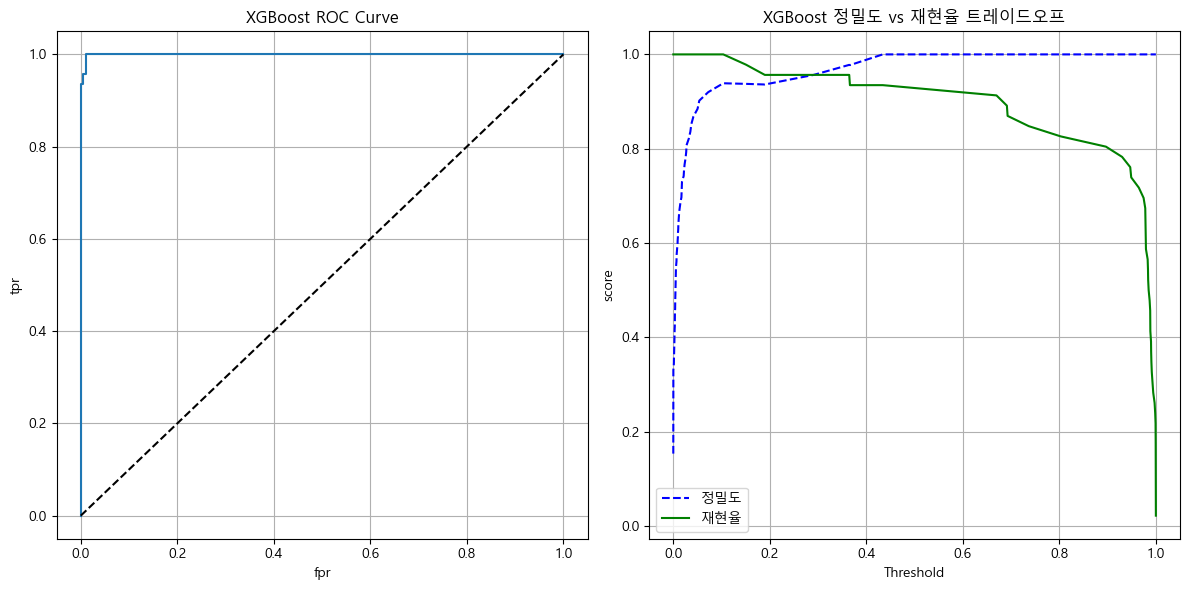

In [11]:
evaluate_model('결정트리', tree_model)
evaluate_model('XGBoost', xgb_model)

### 모델별 변수 중요도 시각화

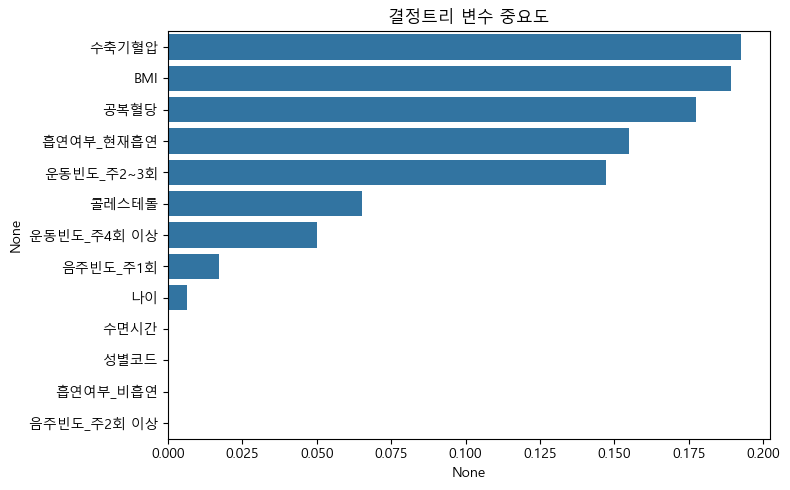

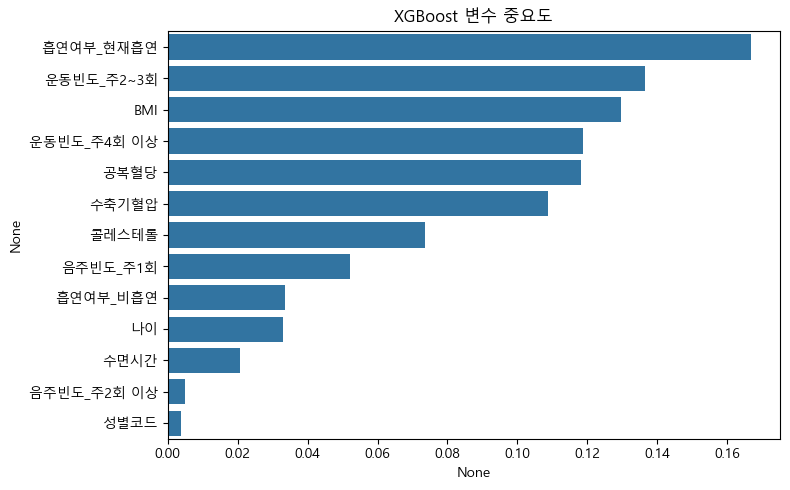

In [12]:
def importance_model(mod_name, mod):
    feature_name = X.columns
    importances = pd.Series(mod.feature_importances_, index=feature_name).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=importances, y=importances.index)
    plt.title(f'{mod_name} 변수 중요도')
    plt.tight_layout()
    plt.show()
importance_model('결정트리', tree_model)
importance_model('XGBoost', xgb_model)